In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [69]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
df_year = pd.read_csv("./data_important/faculties_gender_race_year_v2.csv")
df = pd.read_csv("./data_important/faculties_gender_race.csv")

df_overall = df.drop(columns=['Department']).drop_duplicates()
df.shape, df_overall.shape, df_year.shape

((749, 13), (692, 12), (40368, 13))

In [8]:
df_year_overall = df_year.drop(columns=['Department']).drop_duplicates()
df_year_overall = df_year_overall.drop(columns=['Id']).sort_values(by=['Year']).dropna(subset=['Year'])
df_year_overall = df_year_overall[(df_year_overall.Year != 'Suppl')
                                 & (df_year_overall.Year != 'First Serie.1 ')
                                 & (df_year_overall.Year != 'No Issue')
                                 & (df_year_overall.Year != '1')
                                 & (df_year_overall.Year != '2')]
df_year_overall.head(2)

,Name,LastName,FirstName,Gender,RankName,Race,Year,ArticleCount,ConfProcCount,GrantCount,PatentCount
36798,"SLOCUM, ALEXANDER H",SLOCUM,ALEXANDER,Male,Professor,PCTWHITE,1900,1.0,0.0,0.0,0.0
37401,"BOVE, V MICHAEL",BOVE,V,Female,Other,PCTWHITE,1917,1.0,0.0,0.0,0.0


# Gender

In [76]:
df_gender = df_year_overall.groupby(by=['Year', 'Gender']).sum().reset_index()
v = df_gender.Year.value_counts()
missing = df_gender[~df_gender.Year.isin(v.index[v.gt(1)])]
suppl_df = pd.DataFrame(columns=['Year', 'Gender', 'ArticleCount', 'ConfProcCount', 'GrantCount', 'PatentCount'])
row, col = missing.shape

for i in range(row):
    if missing.iloc[[i]].Gender.values[0] == 'Male':
        suppl_df.loc[len(suppl_df.index)] = [missing.iloc[[i]].Year.values[0], 'Female', 0, 0, 0, 0]
    else:
        suppl_df.loc[len(suppl_df.index)] = [missing.iloc[[i]].Year.values[0], 'Male', 0, 0, 0, 0]

df_gender = pd.concat([df_gender, suppl_df], ignore_index=True).sort_values(by=['Year'])
df_gender = df_gender[df_gender.Year > '1971']
df_gender.head(2)

,Year,Gender,ArticleCount,ConfProcCount,GrantCount,PatentCount
8,1972,Female,0,0,0,1
9,1972,Male,1,0,0,1


In [84]:
gender = df_overall.groupby(by=['RankName', 'Gender']).count()[['Id']].reset_index()

f = gender[(gender.RankName=='Professor') & (gender.Gender=='Female')].Id.values[0]
m = gender[(gender.RankName=='Professor') & (gender.Gender=='Male')].Id.values[0]

fidx = f/(f+m)
midx = m/(f+m)

year = df_gender.Year.drop_duplicates()

50

# Race

In [81]:
df_race = df_year_overall.groupby(by=['Year', 'Race']).sum().reset_index()
races = ['PCTWHITE', 'PCTAPI', 'PCTBLACK', 'PCTHISPANIC']
v = df_race.Year.value_counts()
missing = df_race[df_race.Year.isin(v.index[v.lt(4)])]
suppl_df = pd.DataFrame(columns=['Year', 'Race', 'ArticleCount', 'ConfProcCount', 'GrantCount', 'PatentCount'])
row, col = missing.shape

for i in range(row):
    year = missing.iloc[[i]].Year.values[0]
    exist = list(missing[missing.Year == year].Race.values)
    diff = list(set(races) - set(exist))
    while len(diff) > 0:
        suppl_df.loc[len(suppl_df.index)] = [missing.iloc[[i]].Year.values[0], diff.pop(), 0, 0, 0, 0]
suppl_df = suppl_df.drop_duplicates()

df_race = pd.concat([df_race, suppl_df], ignore_index=True).sort_values(by=['Year'])
df_race = df_race[df_race.Year > '1971']
df_race.head(2)

,Year,Race,ArticleCount,ConfProcCount,GrantCount,PatentCount
174,1972,PCTHISPANIC,0,0,0,0
175,1972,PCTBLACK,0,0,0,0


In [95]:
race = df_overall.groupby(by=['RankName', 'Race']).count()[['Id']].reset_index()

wh = race[(race.RankName=='Professor') & (race.Race=='PCTWHITE')].Id.values[0]
ap = race[(race.RankName=='Professor') & (race.Race=='PCTAPI')].Id.values[0]
bl = race[(race.RankName=='Professor') & (race.Race=='PCTBLACK')].Id.values[0]
hp = race[(race.RankName=='Professor') & (race.Race=='PCTHISPANIC')].Id.values[0]

## Patent

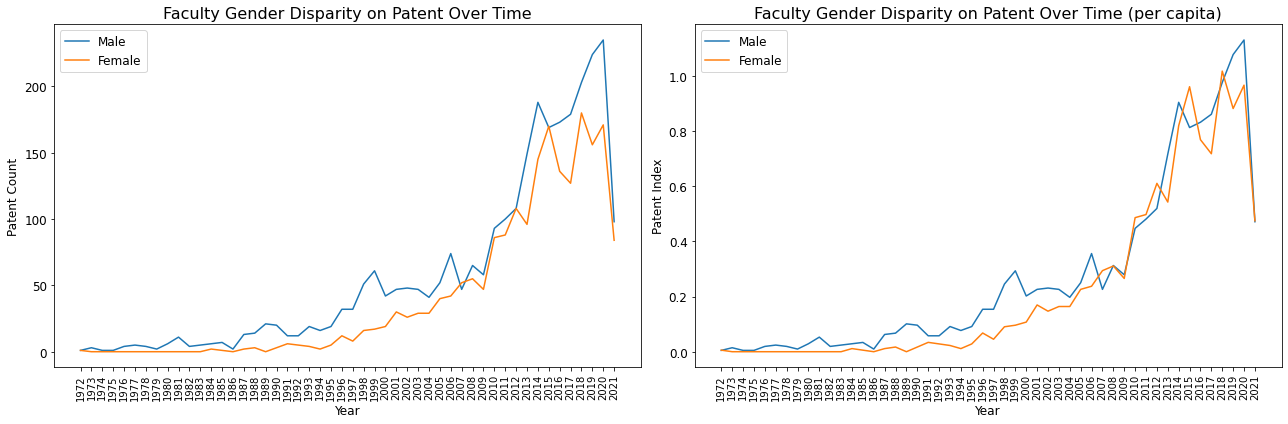

In [91]:
patent_male = df_gender[df_gender.Gender == 'Male'].PatentCount
patent_female = df_gender[df_gender.Gender == 'Female'].PatentCount

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

ax1.plot(year, patent_male)
ax1.plot(year, patent_female)
ax1.legend(['Male', 'Female'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Patent Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Faculty Gender Disparity on Patent Over Time")

sum_pm, sum_pf = sum(patent_male), sum(patent_female)
# patent_male = [num/sum_pm/midx for num in patent_male]
# patent_female = [num/sum_pf/fidx for num in patent_female]
patent_male = [num/m for num in patent_male]
patent_female = [num/f for num in patent_female]

ax2.plot(year, patent_male)
ax2.plot(year, patent_female)
ax2.legend(['Male', 'Female'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Patent Index")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Faculty Gender Disparity on Patent Over Time (per capita)")

plt.tight_layout()

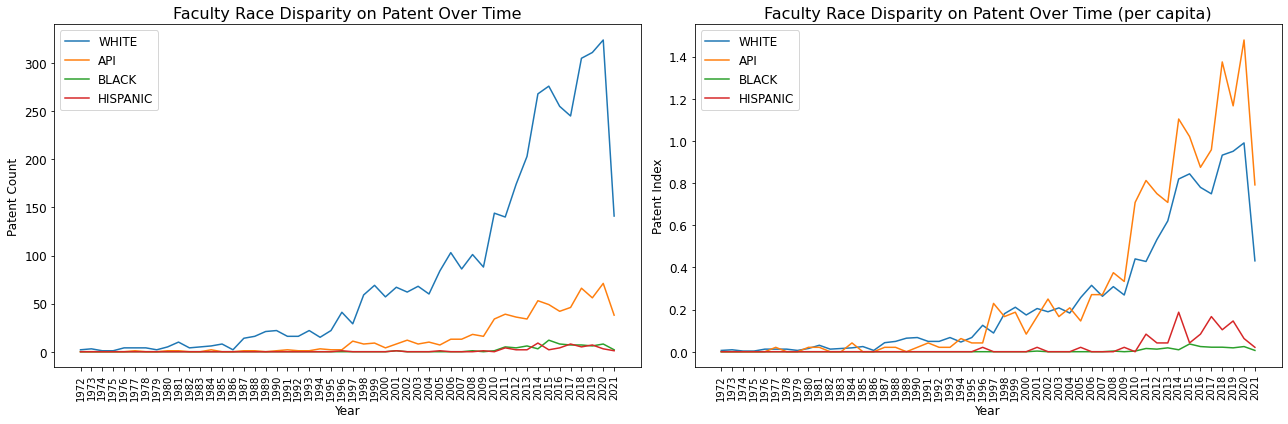

In [96]:
patent_wh = df_race[df_race.Race == 'PCTWHITE'].PatentCount
patent_ap = df_race[df_race.Race == 'PCTAPI'].PatentCount
patent_bl = df_race[df_race.Race == 'PCTBLACK'].PatentCount
patent_hp = df_race[df_race.Race == 'PCTHISPANIC'].PatentCount

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

ax1.plot(year, patent_wh)
ax1.plot(year, patent_ap)
ax1.plot(year, patent_bl)
ax1.plot(year, patent_hp)
ax1.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Patent Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Faculty Race Disparity on Patent Over Time")


patent_wh = [num/wh for num in patent_wh]
patent_ap = [num/ap for num in patent_ap]
patent_bl = [num/wh for num in patent_bl]
patent_hp = [num/ap for num in patent_hp]

ax2.plot(year, patent_wh)
ax2.plot(year, patent_ap)
ax2.plot(year, patent_bl)
ax2.plot(year, patent_hp)
ax2.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Patent Index")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Faculty Race Disparity on Patent Over Time (per capita)")

plt.tight_layout()


## Article

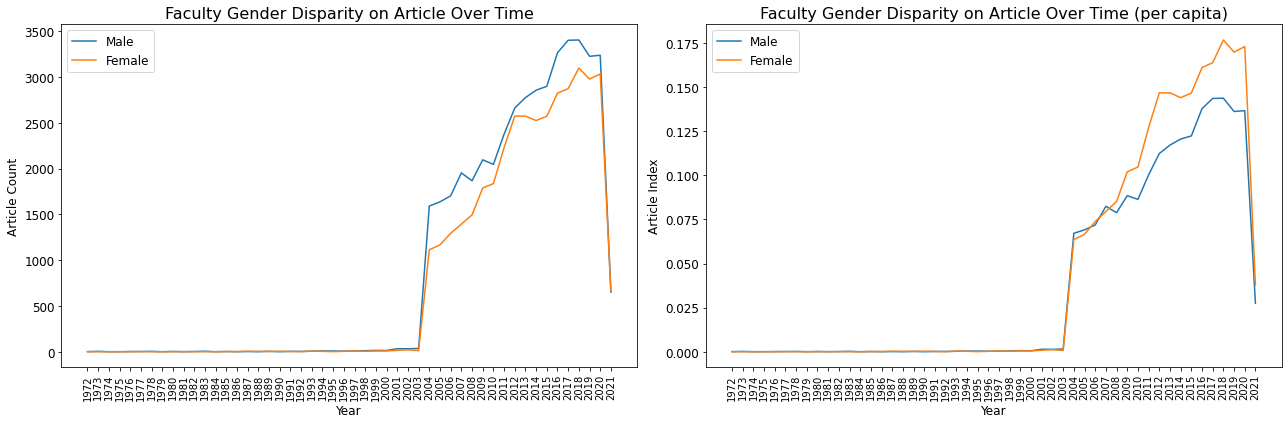

In [92]:
article_male = df_gender[df_gender.Gender == 'Male'].ArticleCount
article_female = df_gender[df_gender.Gender == 'Female'].ArticleCount

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

ax1.plot(year, article_male)
ax1.plot(year, article_female)
ax1.legend(['Male', 'Female'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Article Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Faculty Gender Disparity on Article Over Time")

sum_pm, sum_pf = sum(article_male), sum(article_female)
article_male = [num/sum_pm/midx for num in article_male]
article_female = [num/sum_pf/fidx for num in article_female]


ax2.plot(year, article_male)
ax2.plot(year, article_female)
ax2.legend(['Male', 'Female'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Article Index")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Faculty Gender Disparity on Article Over Time (per capita)")

plt.tight_layout()

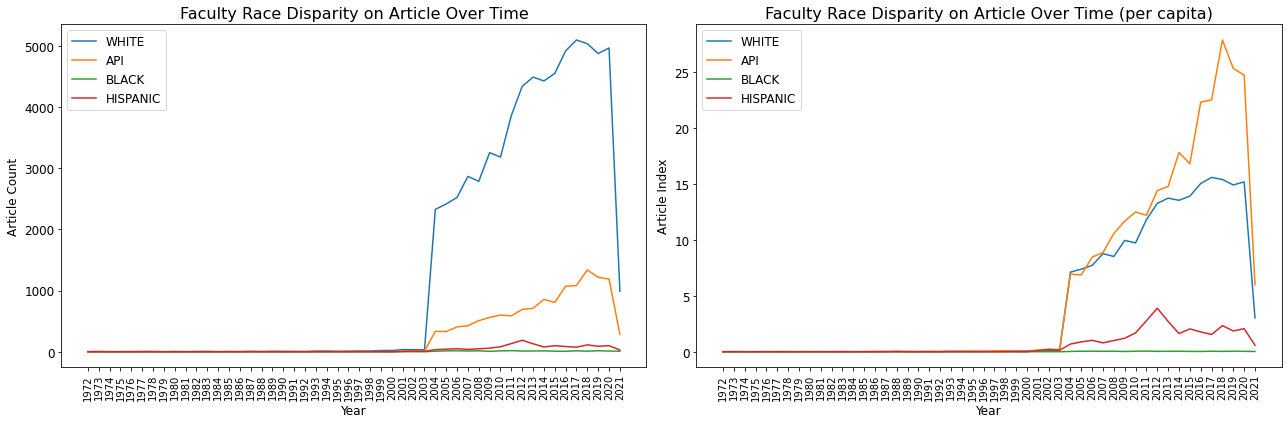

In [97]:
article_wh = df_race[df_race.Race == 'PCTWHITE'].ArticleCount
article_ap = df_race[df_race.Race == 'PCTAPI'].ArticleCount
article_bl = df_race[df_race.Race == 'PCTBLACK'].ArticleCount
article_hp = df_race[df_race.Race == 'PCTHISPANIC'].ArticleCount

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

ax1.plot(year, article_wh)
ax1.plot(year, article_ap)
ax1.plot(year, article_bl)
ax1.plot(year, article_hp)
ax1.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Article Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Faculty Race Disparity on Article Over Time")


article_wh = [num/wh for num in article_wh]
article_ap = [num/ap for num in article_ap]
article_bl = [num/wh for num in article_bl]
article_hp = [num/ap for num in article_hp]

ax2.plot(year, article_wh)
ax2.plot(year, article_ap)
ax2.plot(year, article_bl)
ax2.plot(year, article_hp)
ax2.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Article Index")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Faculty Race Disparity on Article Over Time (per capita)")

plt.tight_layout()


## Conference

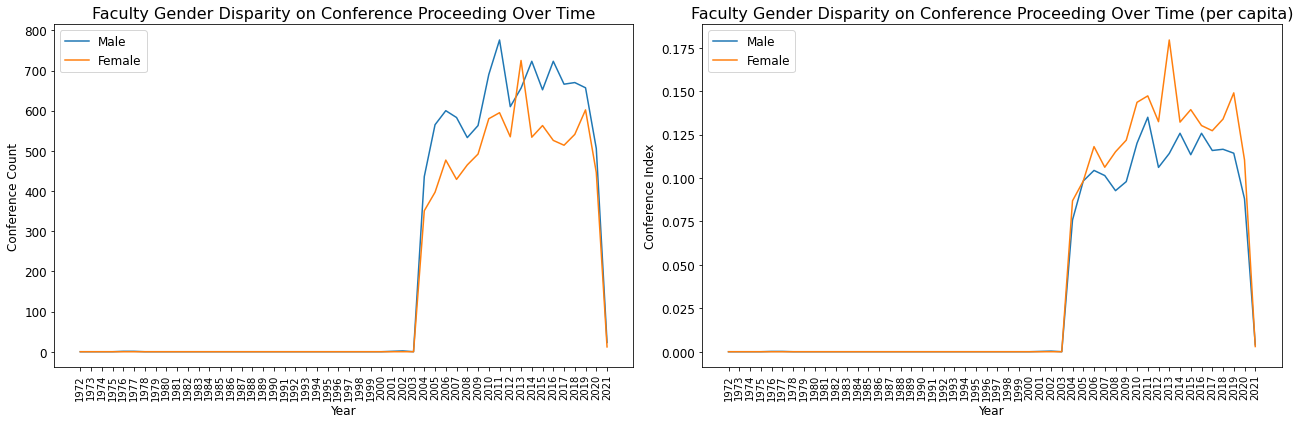

In [93]:
conf_male = df_gender[df_gender.Gender == 'Male'].ConfProcCount
conf_female = df_gender[df_gender.Gender == 'Female'].ConfProcCount

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

ax1.plot(year, conf_male)
ax1.plot(year, conf_female)
ax1.legend(['Male', 'Female'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Conference Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Faculty Gender Disparity on Conference Proceeding Over Time")

sum_pm, sum_pf = sum(conf_male), sum(conf_female)
conf_male = [num/sum_pm/midx for num in conf_male]
conf_female = [num/sum_pf/fidx for num in conf_female]


ax2.plot(year, conf_male)
ax2.plot(year, conf_female)
ax2.legend(['Male', 'Female'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Conference Index")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Faculty Gender Disparity on Conference Proceeding Over Time (per capita)")

plt.tight_layout()

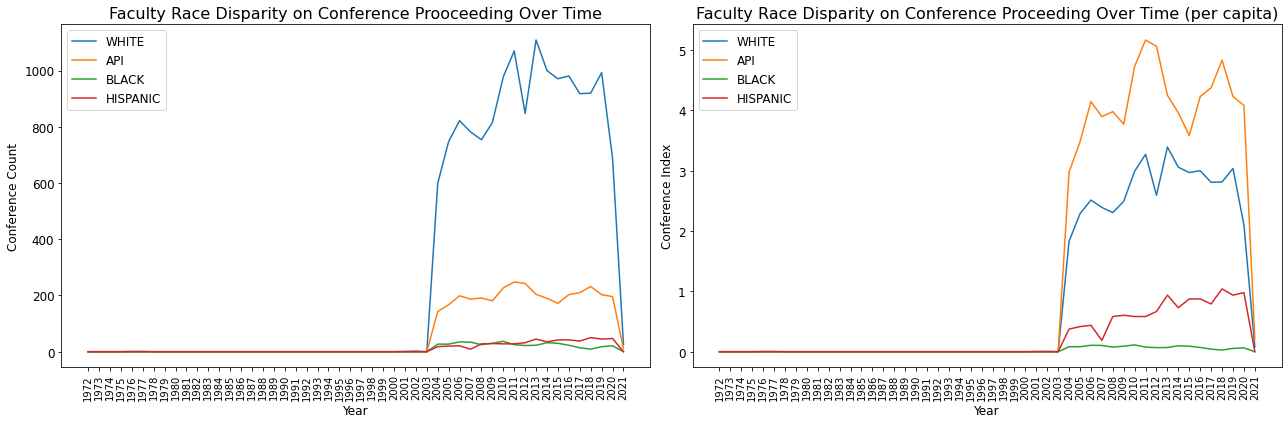

In [100]:
conf_wh = df_race[df_race.Race == 'PCTWHITE'].ConfProcCount
conf_ap = df_race[df_race.Race == 'PCTAPI'].ConfProcCount
conf_bl = df_race[df_race.Race == 'PCTBLACK'].ConfProcCount
conf_hp = df_race[df_race.Race == 'PCTHISPANIC'].ConfProcCount

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

ax1.plot(year, conf_wh)
ax1.plot(year, conf_ap)
ax1.plot(year, conf_bl)
ax1.plot(year, conf_hp)
ax1.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Conference Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Faculty Race Disparity on Conference Prooceeding Over Time")


conf_wh = [num/wh for num in conf_wh]
conf_ap = [num/ap for num in conf_ap]
conf_bl = [num/wh for num in conf_bl]
conf_hp = [num/ap for num in conf_hp]

ax2.plot(year, conf_wh)
ax2.plot(year, conf_ap)
ax2.plot(year, conf_bl)
ax2.plot(year, conf_hp)
ax2.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Conference Index")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Faculty Race Disparity on Conference Proceeding Over Time (per capita)")

plt.tight_layout()


## Grant

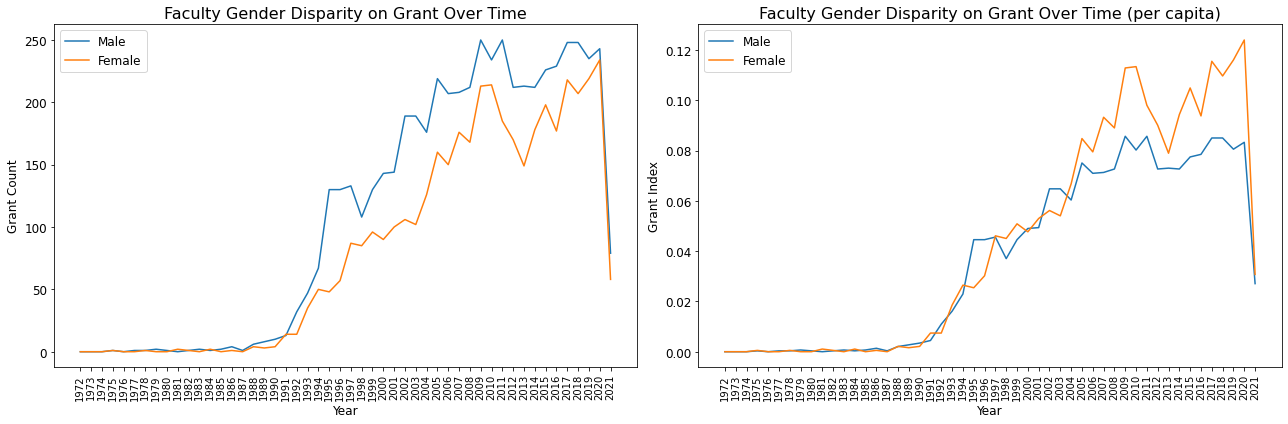

In [94]:
grant_male = df_gender[df_gender.Gender == 'Male'].GrantCount
grant_female = df_gender[df_gender.Gender == 'Female'].GrantCount

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

ax1.plot(year, grant_male)
ax1.plot(year, grant_female)
ax1.legend(['Male', 'Female'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Grant Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Faculty Gender Disparity on Grant Over Time")

sum_pm, sum_pf = sum(grant_male), sum(grant_female)
grant_male = [num/sum_pm/midx for num in grant_male]
grant_female = [num/sum_pf/fidx for num in grant_female]


ax2.plot(year, grant_male)
ax2.plot(year, grant_female)
ax2.legend(['Male', 'Female'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Grant Index")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Faculty Gender Disparity on Grant Over Time (per capita)")

plt.tight_layout()


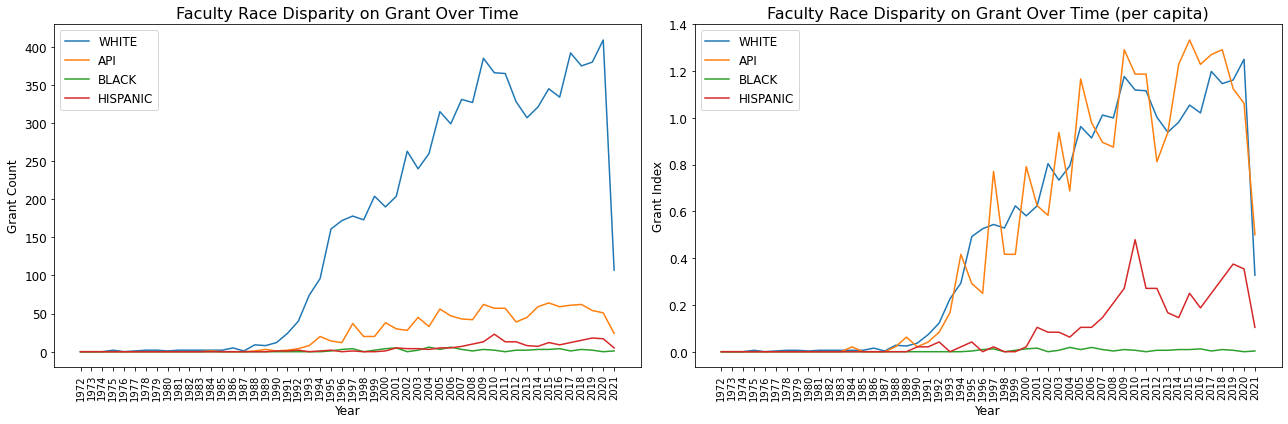

In [98]:
grant_wh = df_race[df_race.Race == 'PCTWHITE'].GrantCount
grant_ap = df_race[df_race.Race == 'PCTAPI'].GrantCount
grant_bl = df_race[df_race.Race == 'PCTBLACK'].GrantCount
grant_hp = df_race[df_race.Race == 'PCTHISPANIC'].GrantCount

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

ax1.plot(year, grant_wh)
ax1.plot(year, grant_ap)
ax1.plot(year, grant_bl)
ax1.plot(year, grant_hp)
ax1.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Grant Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Faculty Race Disparity on Grant Over Time")


grant_wh = [num/wh for num in grant_wh]
grant_ap = [num/ap for num in grant_ap]
grant_bl = [num/wh for num in grant_bl]
grant_hp = [num/ap for num in grant_hp]

ax2.plot(year, grant_wh)
ax2.plot(year, grant_ap)
ax2.plot(year, grant_bl)
ax2.plot(year, grant_hp)
ax2.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Grant Index")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Faculty Race Disparity on Grant Over Time (per capita)")

plt.tight_layout()


In [31]:
df_year.PatentCount.sum()

43865.0

In [41]:
df_year_overall.PatentCount.sum()

4828.0

In [51]:
# before drop duplicate: 40368 rows × 12 columns
# after drop duplicates: 13308 rows × 12 columns
df_year.drop(columns=['Department']).drop_duplicates().sort_values(by=['Year']).dropna(subset=['Year']).PatentCount.sum()

6815.0

In [24]:
sum(patent_male)

2825.0

In [25]:
sum(patent_female)

2003.0

In [58]:
df_gender.ArticleCount.sum()

81967.0

In [36]:
df_year_overall.groupby(by=['Year', 'Gender'])[['PatentCount']].agg('sum')

PatentCount
Year Gender             
1900 Male            0.0
1917 Female          0.0
1958 Female          0.0
1959 Female          0.0
1960 Female          0.0
...                  ...
2019 Male          224.0
2020 Female        171.0
     Male          235.0
2021 Female         84.0
     Male           98.0

[102 rows x 1 columns]

In [61]:
df.TotalPatentCount.sum()


8105

In [57]:
temp = df.drop(columns=['Department']).drop_duplicates()
# temp[temp.Year == '2020']
temp

,Id,Name,LastName,FirstName,Gender,RankName,TotalArticleCount,TotalConfProcCount,TotalGrantCount,TotalPatentCount,TotalCourseCount,Race
0,1485,"BALAKRISHNAN, HAMSA",BALAKRISHNAN,HAMSA,Male,Professor,46,63,15,1,2,PCTAPI
1,2030,"BARRETT, STEVEN R. H",BARRETT,STEVEN,Male,Associate,87,7,11,1,2,PCTWHITE
2,2190,"BELOBABA, PETER P",BELOBABA,PETER,Male,Other,24,2,0,0,2,PCTWHITE
3,2695,"BINZEL, RICHARD P",BINZEL,RICHARD,Male,Professor,163,13,23,0,2,PCTWHITE
4,4030,"CAHOY, KERRI",CAHOY,KERRI,Female,Associate,47,72,45,8,3,PCTWHITE
...,...,...,...,...,...,...,...,...,...,...,...,...
744,3490,"WILLIAMS, MICHAEL",WILLIAMS,MICHAEL,Male,Associate,769,22,12,0,1,PCTWHITE
745,14775,"WINSLOW, LINDLEY",WINSLOW,LINDLEY,Female,Assistant,88,23,5,0,1,PCTWHITE
746,23785,"WUKITCH, STEPHEN JAMES",WUKITCH,STEPHEN,Male,Other,145,45,4,0,0,PCTWHITE
747,3450,"WYSLOUCH, BOLESLAW",WYSLOUCH,BOLESLAW,Male,Professor,1053,10,35,0,0,PCTWHITE
